In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def add_noise(x, mode='crop', elementwise=False):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            pass
        elif mode == 'gaussian':
            pass    
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

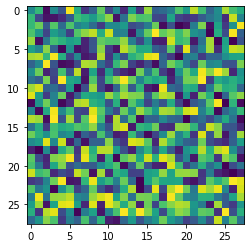

In [210]:
img = (np.random.rand(1, 1, 28, 28) - .5)/.5
plt.imshow(img.reshape(28, 28))

In [315]:
imgs = []

for neuron_n in range(64):
    # случайное изображение, которое мы будем оптимизировать
    img = torch.tensor((np.random.rand(1, 1, 28, 28) - .5)/.5, dtype=torch.float, requires_grad=True)
    # Тренируем изображение, лернинг рейт поставим побольше, чтобы изменения были заметны сразу
    adam = optim.Adam([img], lr=1e-4)
    adam.zero_grad()

    for i in range(20000):
        # максимизируем активацию первого латентного нейрона, лосс ей противоположен
        loss = -models['64'].E(img.view([-1, 28*28]))[0][neuron_n]
        # 
        loss.backward()
        adam.step()

    imgs.append(img.view(28, 28).detach().numpy())

(array([7533., 7998., 7891., 2101.,    0.,    0., 2083., 7594., 7663.,
        7313.]),
 array([-3.0813200e+00, -2.4646084e+00, -1.8478969e+00, -1.2311853e+00,
        -6.1447376e-01,  2.2377968e-03,  6.1894935e-01,  1.2356609e+00,
         1.8523725e+00,  2.4690840e+00,  3.0857956e+00], dtype=float32),
 <a list of 10 Patch objects>)

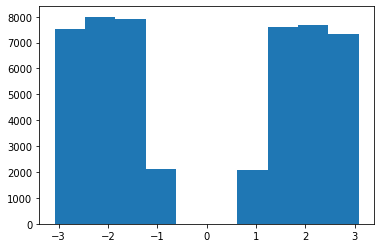

In [329]:
plt.hist(np.array(imgs).reshape([-1]))

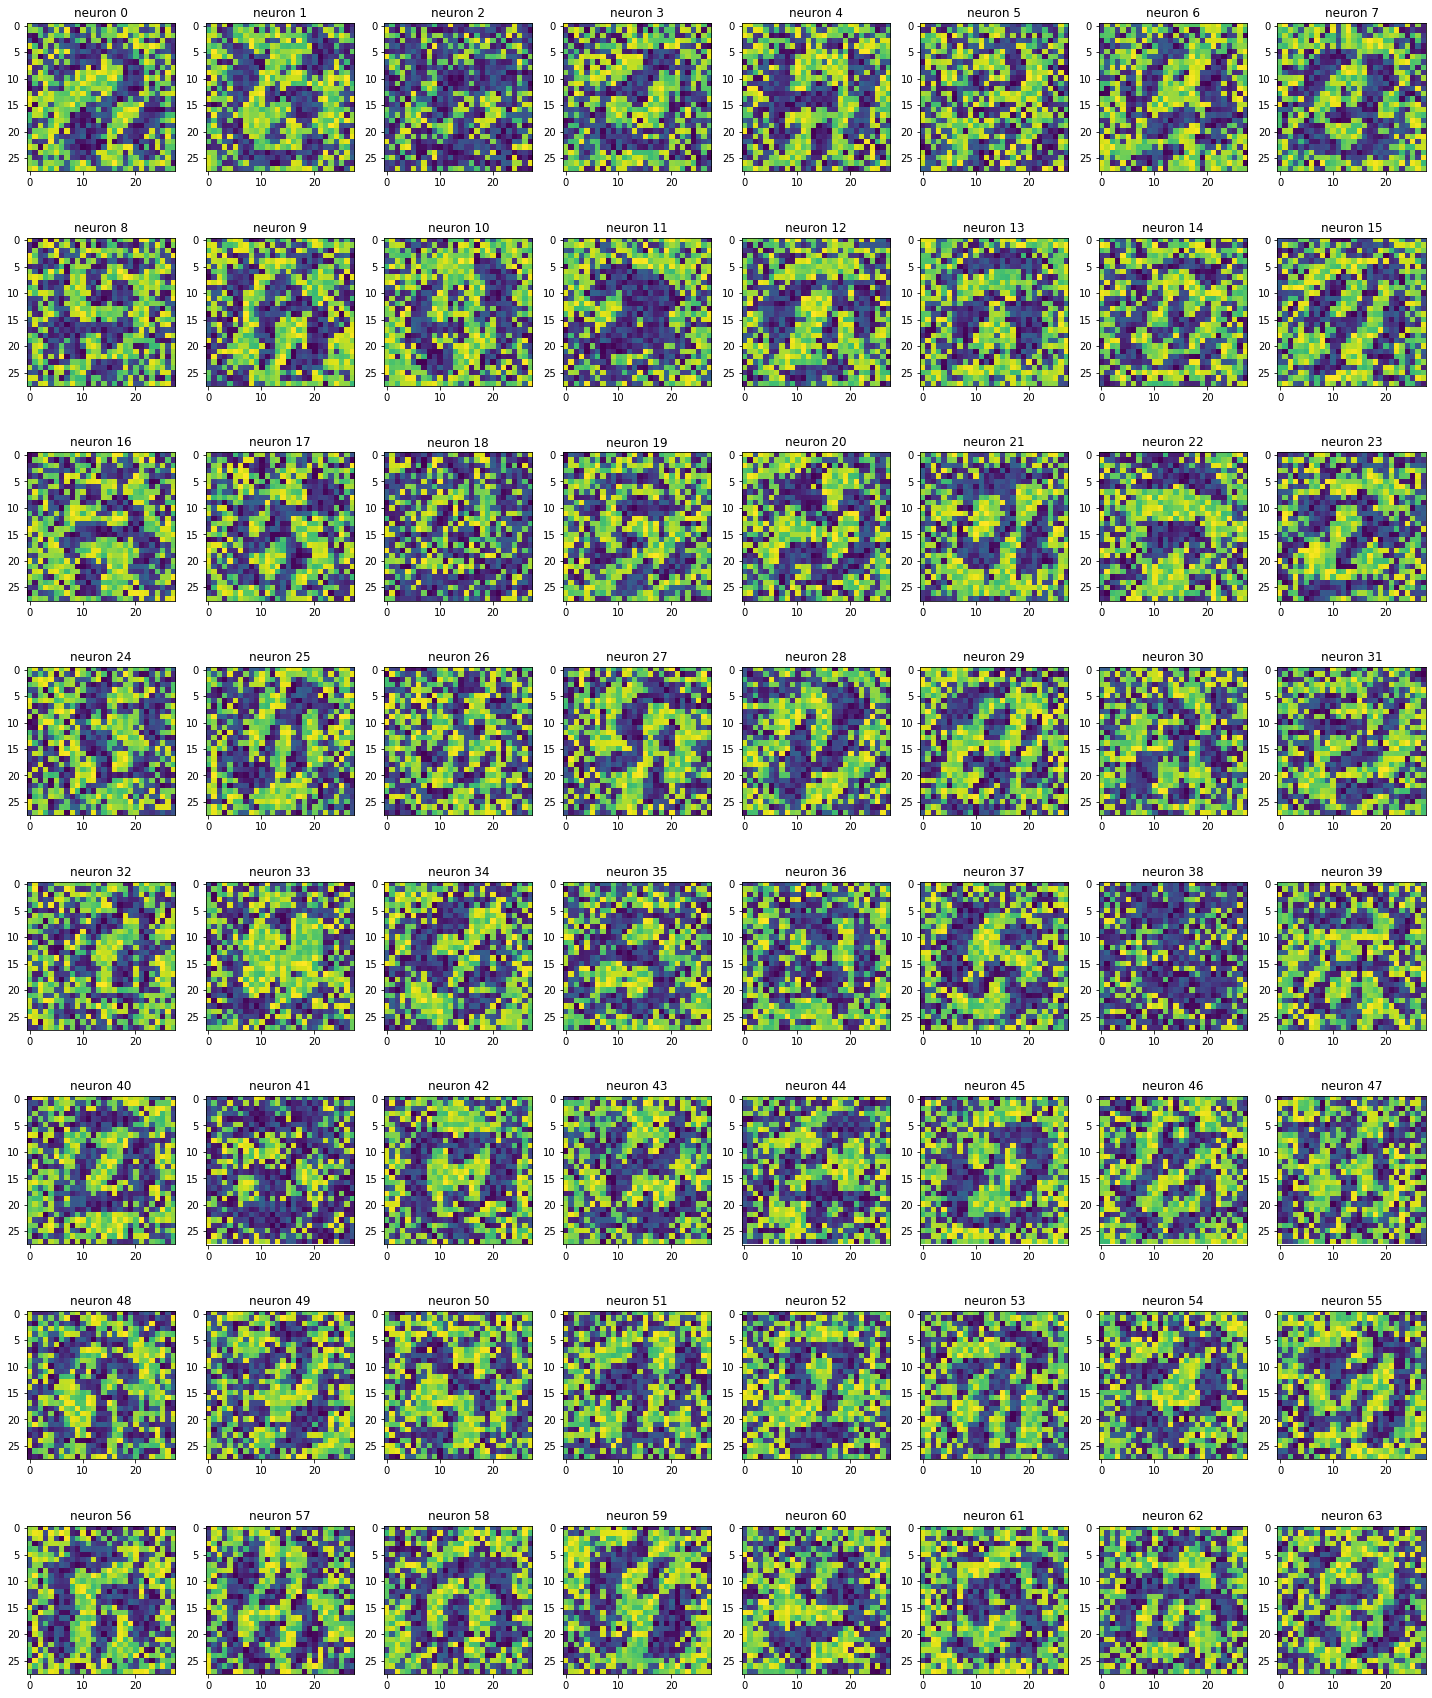

In [317]:
f = plt.figure(figsize=(20,24))

ncols = 8

for i, img in enumerate(imgs):
    ax = f.add_subplot(np.ceil(len(imgs)/ncols), ncols, i+1)
    plt.imshow(img)
    ax.set_title('neuron %d' % i)
    
plt.tight_layout()

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 16: 0.999211 32: 0.980482 64: 1.005211
Train Epoch: 1 [30000/60000] 16: 0.825608 32: 0.637916 64: 0.441639
Train Epoch: 1 [60000/60000] 16: 0.626188 32: 0.376326 64: 0.284958
Test set:
16: loss: 0.6305
32: loss: 0.3866
64: loss: 0.2964

Train Epoch: 2 [00000/60000] 16: 0.629923 32: 0.385952 64: 0.296892
Train Epoch: 2 [30000/60000] 16: 0.486488 32: 0.321165 64: 0.281532
Train Epoch: 2 [60000/60000] 16: 0.386151 32: 0.288292 64: 0.264713
Test set:
16: loss: 0.3895
32: loss: 0.2924
64: loss: 0.2693

Train Epoch: 3 [00000/60000] 16: 0.385340 32: 0.288940 64: 0.266601
Train Epoch: 3 [30000/60000] 16: 0.337746 32: 0.280010 64: 0.258032
Train Epoch: 3 [60000/60000] 16: 0.315516 32: 0.279644 64: 0.266187
Test set:
16: loss: 0.3144
32: loss: 0.2774
64: loss: 0.2535

Train Epoch: 4 [00000/60000] 16: 0.319745 32: 0.281329 64: 0.257015
Train Epoch: 4 [30000/60000] 16: 0.294929 32: 0.268965 64: 0.240299
Train Epoch: 4 [60000/60000] 16: 0.287658 32: 0.267737 64: 0.23651

In [21]:
data, _ = next(iter(test_loader))
#noized = add_noise(data, elementwise=True)
noized = data
output = models['64'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

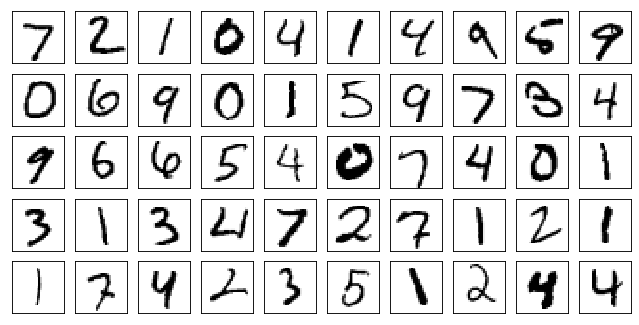

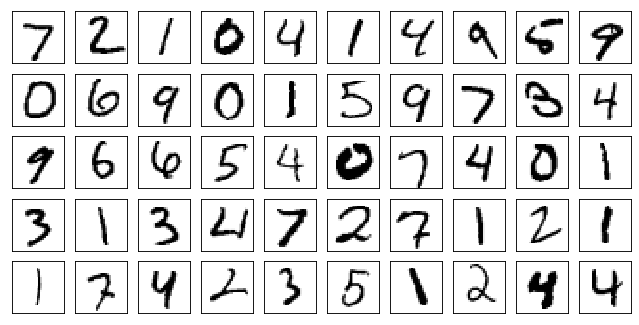

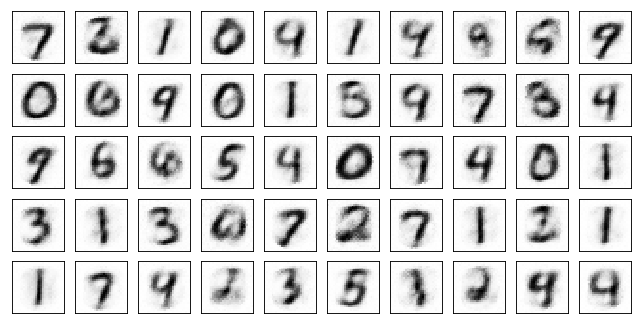

In [22]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

# Оптимизировать изорбажение под активацию конкретного нейрона

In [67]:
neuron = list(models['16'].E.children())[0].weight[0, :]

In [93]:
list(models['16'].E.named_parameters())[0][1].shape

torch.Size([16, 784])

In [74]:
neuron.shape[0]

784

In [72]:
data[0].view([28*28]).shape

torch.Size([784])

In [73]:
torch.dot(neuron, data[0].view([28*28]))

tensor(2.4604, grad_fn=<DotBackward>)

In [ ]:
class NOpt(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear()
    
    def forward(self, x):
        x = self.image()
        return x